# COURSE: A deep understanding of deep learning
## SECTION: CNN milestone projects
### LECTURE: Project 2: CIFAR10 Autoencoder
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202305

In [15]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

# for importing data
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

<ipython-input-15-e7b0751299a6>:15: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [16]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Import the CIFAR dataset

In [17]:
# transformations
transform = T.Compose([ T.ToTensor(),
                        T.Normalize([.5,.5,.5],[.5,.5,.5])
                       ])

# import the data and simultaneously apply the transform
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,  download=True, transform=transform)
testset  = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# transform to dataloaders
batchsize    = 32
train_loader = DataLoader(trainset,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(testset, batch_size=256)

Files already downloaded and verified
Files already downloaded and verified


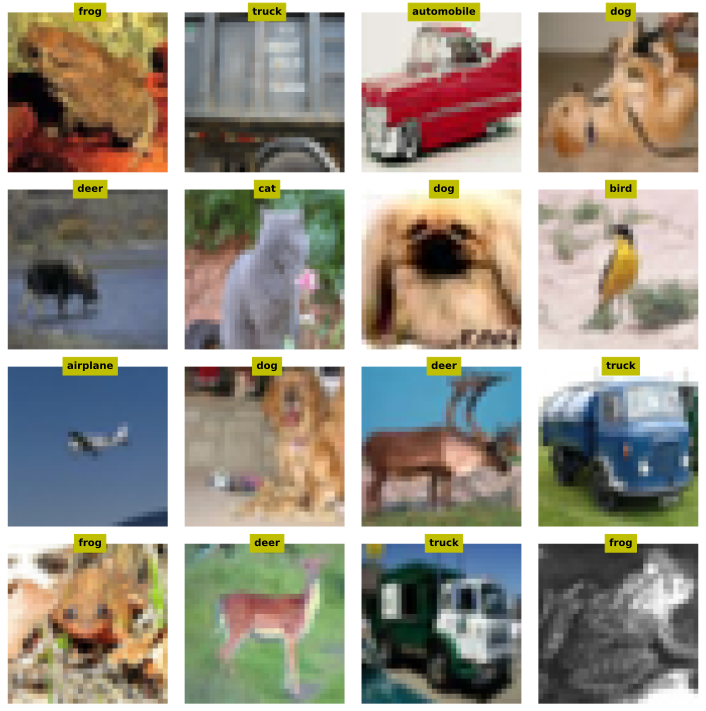

In [18]:
# inspect a few random images

X,y = next(iter(train_loader))

fig,axs = plt.subplots(4,4,figsize=(10,10))

for (i,ax) in enumerate(axs.flatten()):

  # extract that image (need to transpose it back to 32x32x3)
  pic = X.data[i].numpy().transpose((1,2,0))
  pic = pic/2 + .5 # undo normalization

  # and its label
  label = trainset.classes[y[i]]

  # and show!
  ax.imshow(pic)
  ax.text(16,0,label,ha='center',fontweight='bold',color='k',backgroundcolor='y')
  ax.axis('off')

plt.tight_layout()
plt.show()

# Create the CNN-AE model

In [19]:
# create a class for the model
def makeTheAENet(printtoggle=False):

  class aenet(nn.Module):
    def __init__(self,printtoggle):
      super().__init__()

      # print toggle
      self.print = printtoggle

      ### -------------- encoding layers -------------- ###
      # first convolution layer
      self.encconv1  = nn.Conv2d(3,16,4,padding=1,stride=2) # note: using stride instead of pool to downsample
      # output size: (32+2*1-4)/2 + 1 = 16

      # second convolution layer
      self.encconv2  = nn.Conv2d(16,32,4,padding=1,stride=2)
      # output size: (16+2*1-4)/2 + 1 = 8

      # third convolution layer (latent code layer)
      self.latent  = nn.Conv2d(32,64,4,padding=1,stride=2)
      # output size: (8+2*1-4)/2 + 1 = 4


      ### -------------- decoding layers -------------- ###

      # first convolution layer
      self.decconv1  = nn.ConvTranspose2d(64,32,4,padding=1,stride=2)

      # second convolution layer
      self.decconv2  = nn.ConvTranspose2d(32,16,4,padding=1,stride=2)

      # third convolution layer (output)
      self.output  = nn.ConvTranspose2d(16,3,4,padding=1,stride=2)


    def forward(self,x):

      if self.print: print(f'Input: {list(x.shape)}')

      # first encoder layer
      x = F.leaky_relu( self.encconv1(x) )
      if self.print: print(f'First encoder block: {list(x.shape)}')

      # second encoder layer
      x = F.leaky_relu( self.encconv2(x) )
      if self.print: print(f'Second encoder block: {list(x.shape)}')

      # latent layer
      x = F.leaky_relu( self.latent(x) )
      if self.print: print(f'Third encoder block: {list(x.shape)}')




      # first decoder block
      x = F.leaky_relu( self.decconv1(x) )
      if self.print: print(f'First decoder block: {list(x.shape)}')

      # second decoder block
      x = F.leaky_relu( self.decconv2(x) )
      if self.print: print(f'Second decoder block: {list(x.shape)}')

      # third decoder block (output)
      x = F.leaky_relu( self.output(x) )
      if self.print: print(f'Decoder output: {list(x.shape)}')

      return x

  # create the model instance
  net = aenet(printtoggle)

  # loss function
  lossfun = nn.MSELoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001,weight_decay=1e-5)

  return net,lossfun,optimizer


In [20]:
# test the model with one batch
aenet,lossfun,optimizer = makeTheAENet(True)

X,y = next(iter(train_loader))
yHat = aenet(X)

# now compute the loss
loss = lossfun(yHat,X)
print(' ')
print('Loss:')
print(loss)

Input: [32, 3, 32, 32]
First encoder block: [32, 16, 16, 16]
Second encoder block: [32, 32, 8, 8]
Third encoder block: [32, 64, 4, 4]
First decoder block: [32, 32, 8, 8]
Second decoder block: [32, 16, 16, 16]
Decoder output: [32, 3, 32, 32]
 
Loss:
tensor(0.2548, grad_fn=<MseLossBackward0>)


# Create a function that trains the AE model

In [21]:
# a function that trains the model

def function2trainTheAEModel(net,lossfun,optimizer):

  # number of epochs
  numepochs = 20

  # send the model to the GPU
  net.to(device)

  # initialize losses
  trainLoss = torch.zeros(numepochs)
  testLoss  = torch.zeros(numepochs)


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    net.train() # switch to train mode
    batchLoss = []

    for X,y in train_loader:

      # push data to GPU
      X = X.to(device)
      y = y.to(device)

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,X)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss and accuracy from this batch
      batchLoss.append(loss.item())
    # end of batch loop...

    # and get average losses and accuracies across the batches
    trainLoss[epochi] = np.mean(batchLoss)


    #### test performance (here done in batches!)
    net.eval() # switch to test mode
    batchLoss = []

    for X,y in test_loader:

      # push data to GPU
      X = X.to(device)
      y = y.to(device)

      # forward pass and loss
      with torch.no_grad():
        yHat = net(X)
        loss = lossfun(yHat,X)

      # loss and accuracy from this batch
      batchLoss.append(loss.item())
    # end of batch loop...

    # and get average losses and accuracies across the batches
    testLoss[epochi] = np.mean(batchLoss)

  # end epochs

  # function output
  return trainLoss,testLoss,net

# Run the AE model and show the results!

In [22]:
# ~5 minutes with 15 epochs on GPU

# create a new model (comment out to re-train)
netAE,lossfun,optimizer = makeTheAENet()

trainLossAE,testLossAE,netAE = function2trainTheAEModel(netAE,lossfun,optimizer)

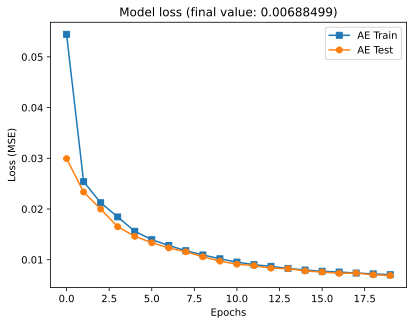

In [23]:
plt.plot(trainLossAE,'s-',label='AE Train')
plt.plot(testLossAE,'o-',label='AE Test')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Model loss (final value: %g)'%testLossAE[-1])
plt.legend()

plt.show()

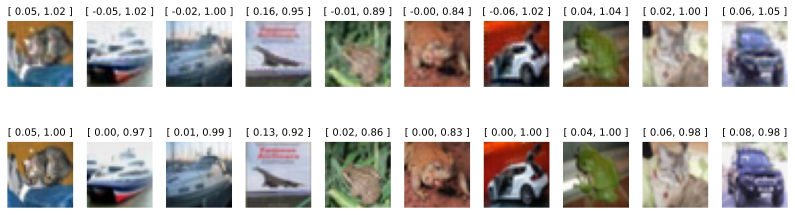

In [24]:
## show some random examples

# get some data
X,y = next(iter(test_loader))

# forward pass and loss
netAE.cpu()
netAE.eval() # switch to test mode
yHat = netAE(X)


fig,axs = plt.subplots(2,10,figsize=(14,4))

for i in range(10):
  pic = yHat[i,:,:,:].detach().numpy().transpose((1,2,0))
  pic = pic/2 + .5 # undo normalization
  axs[0,i].imshow(pic)
  axs[0,i].set_title(f'[ {np.min(pic):.2f}, {np.max(pic):.2f} ]',fontsize=10)
  axs[0,i].axis('off')

  pic = X[i,:,:,:].detach().numpy().transpose((1,2,0))
  pic = pic/2 + .5 # undo normalization
  axs[1,i].imshow(pic)
  axs[1,i].set_title(f'[ {np.min(pic):.2f}, {np.max(pic):.2f} ]',fontsize=10)
  axs[1,i].axis('off')


plt.show()